<a href="https://colab.research.google.com/github/naveen-purohit/deep-learning/blob/master/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
from keras.preprocessing.image import img_to_array
import numpy as np
import glob
import cv2


class dataProcess(object):
    def __init__(self, out_rows, out_cols,
                 npy_path = "/content/drive/MyDrive/segmentation", img_type = "bmp"):

        self.out_rows = out_rows
        self.out_cols = out_cols
        self.img_type = img_type
        self.npy_path = npy_path

    def load_train_data(self):
        print('-'*30)
        print('load train util images...')
        print('-'*30)
        imgs_train = np.load(self.npy_path+"/imgs_train1.npy")
        imgs_mask_train = np.load(self.npy_path+"/imgs_mask_train1.npy")
        print(imgs_train.shape)
        imgs_train = imgs_train.astype('float32')
        imgs_mask_train = imgs_mask_train.astype('float32')
        imgs_train /= 255
        imgs_mask_train /= 255

        imgs_mask_train[imgs_mask_train > 0.5] = 1
        imgs_mask_train[imgs_mask_train <= 0.5] = 0
        return imgs_train,imgs_mask_train


if __name__ == "__main__":
    pass


got model
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 320, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 320, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 320, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________

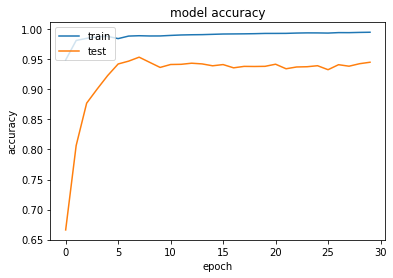

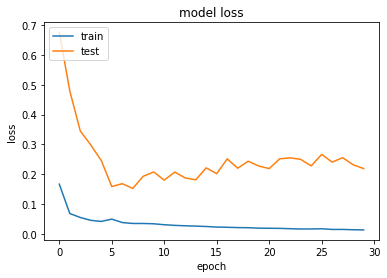

In [9]:

from keras import optimizers
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Conv2D, Input, UpSampling2D, MaxPooling2D,Concatenate
from keras import backend as K
import matplotlib.pyplot as plt
def load_data():
    mydata = dataProcess(240, 320)
    imgs_train, imgs_mask_train = mydata.load_train_data()
    return imgs_train, imgs_mask_train
###########################################################################
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3),kernel_initializer = 'he_normal', padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3),kernel_initializer = 'he_normal', padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x    



def create_model():
    num_filters = [64,128,256,512]
    inputs = Input(shape=[240, 320, 1])

    skip_x = []
    x = inputs
    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPooling2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, 1024)

    num_filters.reverse()
    skip_x.reverse()
    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs,x)

    model.summary()

    return model
###########################################################################

def train():
    model_path = "/content/drive/MyDrive/segmentation/"

    print("got model")
    model = create_model()
    print("loading data")
    imgs_train, imgs_mask_train = load_data()
    print("loading data done")

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

    model_checkpoint = ModelCheckpoint(model_path + 'unet.hdf5', monitor='loss', verbose=1,
                                       save_best_only=True, save_weights_only=True, mode='auto', period=1)
    print('Fitting model...')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, mode='auto')
    lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=6, verbose=0, mode='min', cooldown=0,
                           min_lr=0.000001)
    history=model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=30, verbose=1, validation_split=0.2,
                        shuffle=True,
                        callbacks=[model_checkpoint,lr, early_stop])
     # summarize history for accuracy
    for key in history.history.keys():
       print(key)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(model_path + "accuracy.png")
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(model_path + "loss.png")
    plt.show()
    

if __name__ == '__main__':
    train()
    K.clear_session()

In [5]:
from keras.preprocessing.image import array_to_img
path="/content/drive/MyDrive/segmentation"
data_path = path+"/"+"test"
    
model_path = path
print(model_path)
print(data_path)

img_type = "bmp"

imgs = glob.glob(data_path + "/*." + img_type)
print(imgs)
# import the model
model = create_model()

# load the model
model.load_weights(model_path + '/unet_model.hdf5')
i=1
for imgname in imgs:
  image_rgb = (np.array(cv2.imread(imgname, 0))).astype(np.float32)
  image = np.expand_dims(image_rgb, axis=-1) / 255
  net_in = np.zeros((1, 240, 320, 1), dtype=np.float32)
  net_in[0] = image
  imgs_mask_test = model.predict(net_in)[0]
  img = imgs_mask_test
  img = array_to_img(img)
  img.save(model_path+"/"+"predicted"+"/"+str(i)+".tiff")
  i=i+1;
K.clear_session()

/content/drive/MyDrive/segmentation
/content/drive/MyDrive/segmentation/test
['/content/drive/MyDrive/segmentation/test/073_05_L.bmp', '/content/drive/MyDrive/segmentation/test/073_09_R.bmp', '/content/drive/MyDrive/segmentation/test/073_02_L.bmp', '/content/drive/MyDrive/segmentation/test/073_06_R.bmp', '/content/drive/MyDrive/segmentation/test/073_07_R.bmp', '/content/drive/MyDrive/segmentation/test/073_03_L.bmp', '/content/drive/MyDrive/segmentation/test/073_08_R.bmp', '/content/drive/MyDrive/segmentation/test/073_10_R.bmp', '/content/drive/MyDrive/segmentation/test/073_04_L.bmp']
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 240, 320, 1) 0                                            
_______________________________________________________________________________________________